# Bresenhams Linien-Algorithmus in 3D

Ein Lidar-Sensor steht am Punkt $(x_{0}, y_{0}, z_{0})$ und sendet seinen Laser in eine durch die Winkel $\alpha$ und $\beta$ festgelegte Richtung. Der Sensor misst eine Entfernung bis der Lichtstrahl auf einer Oberfläche auftrifft. Die Messung hat allerdings eine mit der Entfernung steigende Messungenauigkeit.

Numpy beschleunigt berechnungen mit Vektoren und Listen von Vektoren. Matplotlib hilft die Ergebnisse zu visualisieren. Dafür zunächst einige Imports:

In [1]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

Mit einigen tausend Lidar-Messungen lässt sich ein 3D-Modell des Raums erstellen, in denen der Sensor bewegt wird. Als Basis für das Modell dient ein Voxel-Gitter:

In [2]:
a = np.zeros((10, 10, 10), dtype=np.float32)

Für jeden Voxel entlang des Laserstrahls jeder Messung lässt sich anhand des Messwerts und der erwarteten Messungenauigkeit eine Wahrscheinlichkeit angeben, dass an diesem Punkt durchsichtige Luft oder ein undurschsichtiges Objekt wie eine Wand ist. Nur welche Voxel befinden sich „entlang“ des Laserstrahls?

Diese Frage lässt sich mit Bresehams Linien-Algorithmus berechnen. Der Algorithmus diente ursprünglich dazu 1 Pixel breite Linien auf einen 2D-Monitor zu zeichnen. Er funktioniert aber auch in 3D mit Voxeln statt pixeln.

## Wo beginnt die Linie?

Anders als in Bresehams Original-Algorithmus gibt es für die Lidar-Messungen nicht unbedingt ganzzahlige Koordinaten für den Startpunkt `start`$=(x_{0}, y_{0}, z_{0})$. Der Zielpunkt `target`$=(x_{1}, y_{1}, z_{1})$ muss ebenfalls nicht ganzzahlig sein. Beide Punkte müssen nicht innerhalb des Voxel-Rasters liegen.

Eine Gerade ist definiert als: $\begin{bmatrix} x \\ y \\ z \end{bmatrix} = \begin{bmatrix} x_{0} \\ y_{0} \\ z_{0} \end{bmatrix} + p \cdot \begin{bmatrix} x_{1}-x_{0} \\ y_{1}-y_{0} \\ z_{1}-z_{0} \end{bmatrix}$

Um ihren Schnittpunkt mit der Y-Z-Ebene zu bestimmen, muss man nur das Gleichungssystem mit $x=0$ lösen:
$\begin{bmatrix} 0 \\ y \\ z \end{bmatrix} = \begin{bmatrix} x_{0} \\ y_{0} \\ z_{0} \end{bmatrix} + p \cdot \begin{bmatrix} x_{1}-x_{0} \\ y_{1}-y_{0} \\ z_{1}-z_{0} \end{bmatrix}$

Dafür bestimmt man $p$ anhand der X-Koordinate und kann dann dieses $p$ in die Zeilen für Y und Z einsetzen. Glücklicherweise interessiert den Algorithmus nur, ob das berechnete $p$ positiv und kleiner als 1 ist, da nur dann die Gerade am Rand des Voxelgitters startet. Es reicht also zunächst $p$ zu bestimmen: 
$ 0 = x_{0} + p \cdot (x_{1} - x_{0}) \\
\Leftrightarrow p = \frac{-x_{0}}{x_{1}-x_{0}} $

Analog ergibt sich ein $p_{y=0}$ mit $\begin{bmatrix} x \\ 0 \\ z \end{bmatrix}$: $p_{y=0} = \frac{-y_{0}}{y_{1}-y_{0}}$

Und zuletzt $p_{z=0}$ mit $\begin{bmatrix} x \\ y \\ 0 \end{bmatrix}$: $p_{z=0} = \frac{-z_{0}}{z_{1}-z_{0}}$

Die drei $p$ variablen lassen sich mit Numpy effizient in einem Schritt berechnen: $\begin{bmatrix} p_{x=0} \\ p_{y=0} \\ p_{z=0} \end{bmatrix} = \begin{bmatrix} \frac{-x_{0}}{x_{1}-x_{0}} \\ \frac{-y_{0}}{y_{1}-y_{0}} \\ \frac{-z_{0}}{z_{1}-z_{0}} \end{bmatrix}$ `p_0 = -start / start_to_target_vector`

Falls die X-, Y- oder Z-Konponente des Richtungsvektors jedoch negativ ist, muss der Algorithmus stattdessen prüfen, ob der Vektor von außerhalb des Maximums den durch die Voxel definierten Bereich durchquert. Mit dem Optimalen Parameter `step_size` ergibt sich das Maximum als `array_max = np.array(array.shape) * step_size`.

Die $p_{max}$ mit den Ebenen, die die Maximalkanten des Voxel-Kubus berechnen sich folgendermaßen:
$\begin{bmatrix} p_{x=max} \\ p_{y=max} \\ p_{z=max} \end{bmatrix} = \begin{bmatrix} \frac{x_{max}-x_{0}}{x_{1}-x_{0}} \\ \frac{y_{max}-y_{0}}{y_{1}-y_{0}} \\ \frac{z_{max}-z_{0}}{z_{1}-z_{0}} \end{bmatrix}$ `p_max = (array_max - start) / start_to_target_vector`

Die Wahl welcher der beiden möglichen $p$ hängt davon ab, ob der Richtungsvektor vom Ursprung weg oder zum Ursprung hin zeigt. Je nachdem kann Numpy den einen oder den anderen Wert wählen: `np.select([start_to_target_vector >= 0, start_to_target_vector < 0], [p_0, p_max])`. Vom Ergebnis interessiert nur der größte Wert und für den Fall, dass alle $p$ negativ wären, sollte der zuletzt gewählte Wert nie negativ werden. Das alles erledigt die folgende Zeile: `p = np.maximum(np.max(np.select([start_to_target_vector >= 0, start_to_target_vector < 0], [p_0, p_max])), 0)`

Mit diesem $p$ lässt sich nun endlich die X-, Y- und Z-Komponente des Startpunkts berechnen: 

$\begin{bmatrix} x_{start} \\ y_{start} \\ z_{start} \end{bmatrix} = \begin{bmatrix} x_{0} \\ y_{0} \\ z_{0} \end{bmatrix} + p \cdot \begin{bmatrix} x_{1}-x_{0} \\ y_{1}-y_{0} \\ z_{1}-z_{0} \end{bmatrix}$

In Python-Code sieht das so aus:

In [3]:
def find_start_point_in_voxel_grid(start, start_to_target_vector, array, step_size):
    array_max = np.array(array.shape) * step_size
    notzero_array = start_to_target_vector != 0
    p_0 = np.zeros((3,), dtype=np.float32)
    np.divide(0 - start, start_to_target_vector, out=p_0, where=notzero_array)
    p_max = np.zeros((3,), dtype=np.float32)
    np.divide(array_max - start, start_to_target_vector, out=p_max, where=notzero_array)
    p = np.maximum(np.max(np.select([start_to_target_vector >= 0, start_to_target_vector < 0], [p_0, p_max])), 0)
    return start + p * start_to_target_vector

## Linien-Vorbereitungen

Bresehams Algorithmus folgt der Linie entlang ihrer steilsten Achse in 1-Pixel- bzw. 1-Voxel-Schritten. Für die verbleibenden zwei Dimensionen prüft er in jedem Schritt, ob das direkt benachbarte Voxel (in Richtung der steilsten Achse) der Linie noch gut genug folgt, oder ob stattdessen ein seitlich verschobenes Voxel besser passt. Die steilste Achse lässt sich mit dem Vektor $\vec{target} - \vec{start}$ berechnen: `start_to_target_vector = target - start`

Ein Array mit den Nummern aller Dimensionen erzeugt `list(range(len(array.shape)))`. Mit der Numpy-Funktion `argmax()` lässt sich die steilste Dimension leicht bestimmen; da die Richtung auch negativ sein kann, bildet der Algorithmus vorher den Betrag. Die so berechnete Nummer der steilsten Dimension lässt sich nun aus der Liste aller Dimensionen löschen, wodurch die beiden weniger steilen Dimensionen übrig bleiben:

```python
error_dimensions = list(range(len(array.shape)))
steepest_dimension = error_dimensions.pop(np.argmax(np.abs(start_to_target_vector)))
```

Da eine Gerade keine Krümmung hat, entfernt sie sich bei jedem Schritt um den gleichen konstanten Faktor von der steilsten Dimension. Wie weit lässt sich leicht mit dem Vektor vom Start zum Zielpunkt berechnen:

```python
error_per_step = (start_to_target_vector / start_to_target_vector[steepest_dimension]) * step_size
```

Anschließend geht es darum, den ersten Voxel zu bestimmen. Für diesen Punkt ergibt sich dann auch ein initialer Rundungsfehler:

```python
error = np.modf(start_point_in_voxel_grid / step_size)[0]
start_voxel = np.around(start_point_in_voxel_grid / step_size, decimals=0)
```

Die Numpy-Funktion `modf()` gibt zwei Vektoren zurück: Zuerst den Rundungsfehler und danach den ganzzahligen Anteil. Der Bressehnham-Algorithmus braucht aber nur den Rundungsfehler.

Als nächstes geht es darum die Richtung zu bestimmen, in die der Algorithmus der steilsten Achse folgt. Wenn der Vektor vom Start- zum Zielpunkt entlang der steilsten Dimension negativ ist, soll `line_direction` -1 sein, ansonsten 1. Mit einer Typkonvertierung des Booleans vom Vergleich zu einem Integer kommen die Werte 0 und 1 vor. Zu -1 und 1 kommt der Algorthmus durch verdoppeln und anschließend 1 anbziehen:

```python
line_direction = int(start_to_target_vector[steepest_dimension] > 0) * 2 - 1
```

## Linien-Schritte

Nachdem der Startpunkt und der Fehler pro Schritt festgelegt sind, kann der Algorthmus in einer Schleife an der Linie entlang laufen und die passenden Voxel in der Liste `voxels` einsammeln. Die Zählvariable für die Koordinate der steilsten Achse ist `i`. Jeder Schritt baut auf dem vorherigen auf, weshalb `current_voxel` die letzte Position protokolliert. Die beginnt mit einer Kopie von `start_voxel`. `np.copy()` ist notwendig, da die Variable `start_voxel` eine Referenz auf den Vektor enthält und diese in `voxels` archiviert werden soll. In der Kopie kann der Algorithmus Änderungen an den Zahlenwerten der Vektorkomponenten vornehmen, ohne nebenbei auch `start_voxel` zu verändern.

Die Schleife wird mit `while True:` als Endlosschleife gestartet, weil die `if`-Anweisung im Schleifenkörper erst später überprüft, ob sie abgebrochen werden soll. Eine solche Konstruktion ähnelt einer `do {} while`-Schleife in anderen Sprachen, die es in Python so nicht gibt.

Der erste Schritt bei jedem Durchlauf besteht darin `i` voranzuschreiten. Die Richtung ist durch `line_direction` festgelegt und kann daher 1 oder -1 sein. Die nächste Zeile addiert den zusätzlichen Fehler durch den neuen Schritt auf den bereits akkumulierten Fehler. Dank Numpy geht das in einem Befehl für alle Dimensionen:

```python
np.add(error, error_per_step / step_size, out=error)
```

Sollte der Betrag des Fehlers für eine Fehlerachse 0,5 überschreiten, muss der Algorithmus ein Voxel in diese Richtung gehen und 1 vom Fehler abziehen. Das ließe sich mit `if`-Anweisungen und einer Schleife über die Fehlerdimensionen formulieren, was aber Numpys fähigkeiten zum Parallelisieren mehrerer Berechnungen nicht nutzt. Stattdessen erstellt der Algorithmus eine Maske aus Boolean-Werten, wo die Linie einen Schritt zur Seite machen muss und bereitet die Richtung für diesen Schritt für alle Achsen vor:

```python
step_dims = np.abs(error) >= 0.5
step_dir = (error > 0) * 2.0 - 1.0
```

Die Numpy-Funktionen `subtract()` und `add()` nehmen nun die Maske mit dem `where`-Parameter entgegen und führen ihe Berechnung nur dort aus, wo sie `True` ist:

```python
np.subtract(error, step_dir, out=error, where=step_dims)
np.add(current_voxel, step_dir, out=current_voxel, where=step_dims)
```

Nachdem der Schritt nun gemacht und `current_voxel` aktualisiert ist, prüft der Algorithmus ob er schon fertig ist. Wenn eine der Koordinaten von `current_voxel` unter 0 sinkt oder die Größe des Voxelgitters überschreitet, ist der Algorithmus fertig und kann mit `break` aus der Schleife springen. 

Wenn er noch nicht fertig ist, hängt er eine Kopie von `current_voxel` an die `voxels` an und beginnt mit dem nächsten Schleifendurchlauf den nächsten Schritt.

In [4]:
def bresenham(start, target, array, step_size=1.0):
    start_to_target_vector = target - start
    error_dimensions = list(range(len(array.shape)))
    steepest_dimension = error_dimensions.pop(np.argmax(np.abs(start_to_target_vector)))
    print("start_to_target_vector", start_to_target_vector, "  error_dimensions", error_dimensions)
    error_per_step = (start_to_target_vector / np.abs(start_to_target_vector[steepest_dimension])) * step_size
    print("Error per step:", error_per_step)
    start_point_in_voxel_grid = find_start_point_in_voxel_grid(
        start, start_to_target_vector, array, step_size)
    error = np.modf(start_point_in_voxel_grid / step_size)[0]
    start_voxel = np.around(start_point_in_voxel_grid / step_size, decimals=0)
    line_direction = int(start_to_target_vector[steepest_dimension] > 0) * 2 - 1
    voxels = [start_voxel]
    print("Error at start:", error)
    current_voxel = np.copy(start_voxel)
    print(current_voxel)
    while True:
        np.add(error, error_per_step / step_size, out=error)
        print("i:", current_voxel[steepest_dimension], "Error:", error)
        step_dims = np.abs(error) >= 0.5
        step_dir = ((error > 0) * 2.0 - 1.0)
        print("step_dims & step_dir", step_dims, step_dir)
        np.subtract(error, step_dir, out=error, where=step_dims)
        np.add(current_voxel, step_dir, out=current_voxel, where=step_dims)
        print(current_voxel, "Error:", error)
        if np.any(current_voxel < 0) or np.any(current_voxel > np.array(array.shape, dtype=np.float32)): 
            break
        voxels.append(np.copy(current_voxel))
    return voxels

In [5]:
start = np.array([5, 2, 0], dtype=np.float32)
target = np.array([0, 4.5, 3], dtype=np.float32)
step_size = 0.5
voxels = bresenham(start, target, a, step_size=step_size)
voxels

start_to_target_vector [-5.   2.5  3. ]   error_dimensions [1, 2]
Error per step: [-0.5   0.25  0.3 ]
Error at start: [0. 0. 0.]
[10.  4.  0.]
i: 10.0 Error: [-1.   0.5  0.6]
step_dims & step_dir [ True  True  True] [-1.  1.  1.]
[9. 5. 1.] Error: [ 0.         -0.5        -0.39999998]
i: 9.0 Error: [-1.          0.          0.20000005]
step_dims & step_dir [ True False False] [-1. -1.  1.]
[8. 5. 1.] Error: [0.         0.         0.20000005]
i: 8.0 Error: [-1.         0.5        0.8000001]
step_dims & step_dir [ True  True  True] [-1.  1.  1.]
[7. 6. 2.] Error: [ 0.         -0.5        -0.19999993]
i: 7.0 Error: [-1.         0.         0.4000001]
step_dims & step_dir [ True False False] [-1. -1.  1.]
[6. 6. 2.] Error: [0.        0.        0.4000001]
i: 6.0 Error: [-1.         0.5        1.0000001]
step_dims & step_dir [ True  True  True] [-1.  1.  1.]
[5. 7. 3.] Error: [ 0.0000000e+00 -5.0000000e-01  1.1920929e-07]
i: 5.0 Error: [-1.          0.          0.60000014]
step_dims & step_di

[array([10.,  4.,  0.], dtype=float32),
 array([9., 5., 1.], dtype=float32),
 array([8., 5., 1.], dtype=float32),
 array([7., 6., 2.], dtype=float32),
 array([6., 6., 2.], dtype=float32),
 array([5., 7., 3.], dtype=float32),
 array([4., 7., 4.], dtype=float32),
 array([3., 8., 4.], dtype=float32),
 array([2., 8., 5.], dtype=float32),
 array([1., 9., 5.], dtype=float32),
 array([0., 9., 6.], dtype=float32)]

<IPython.core.display.Javascript object>


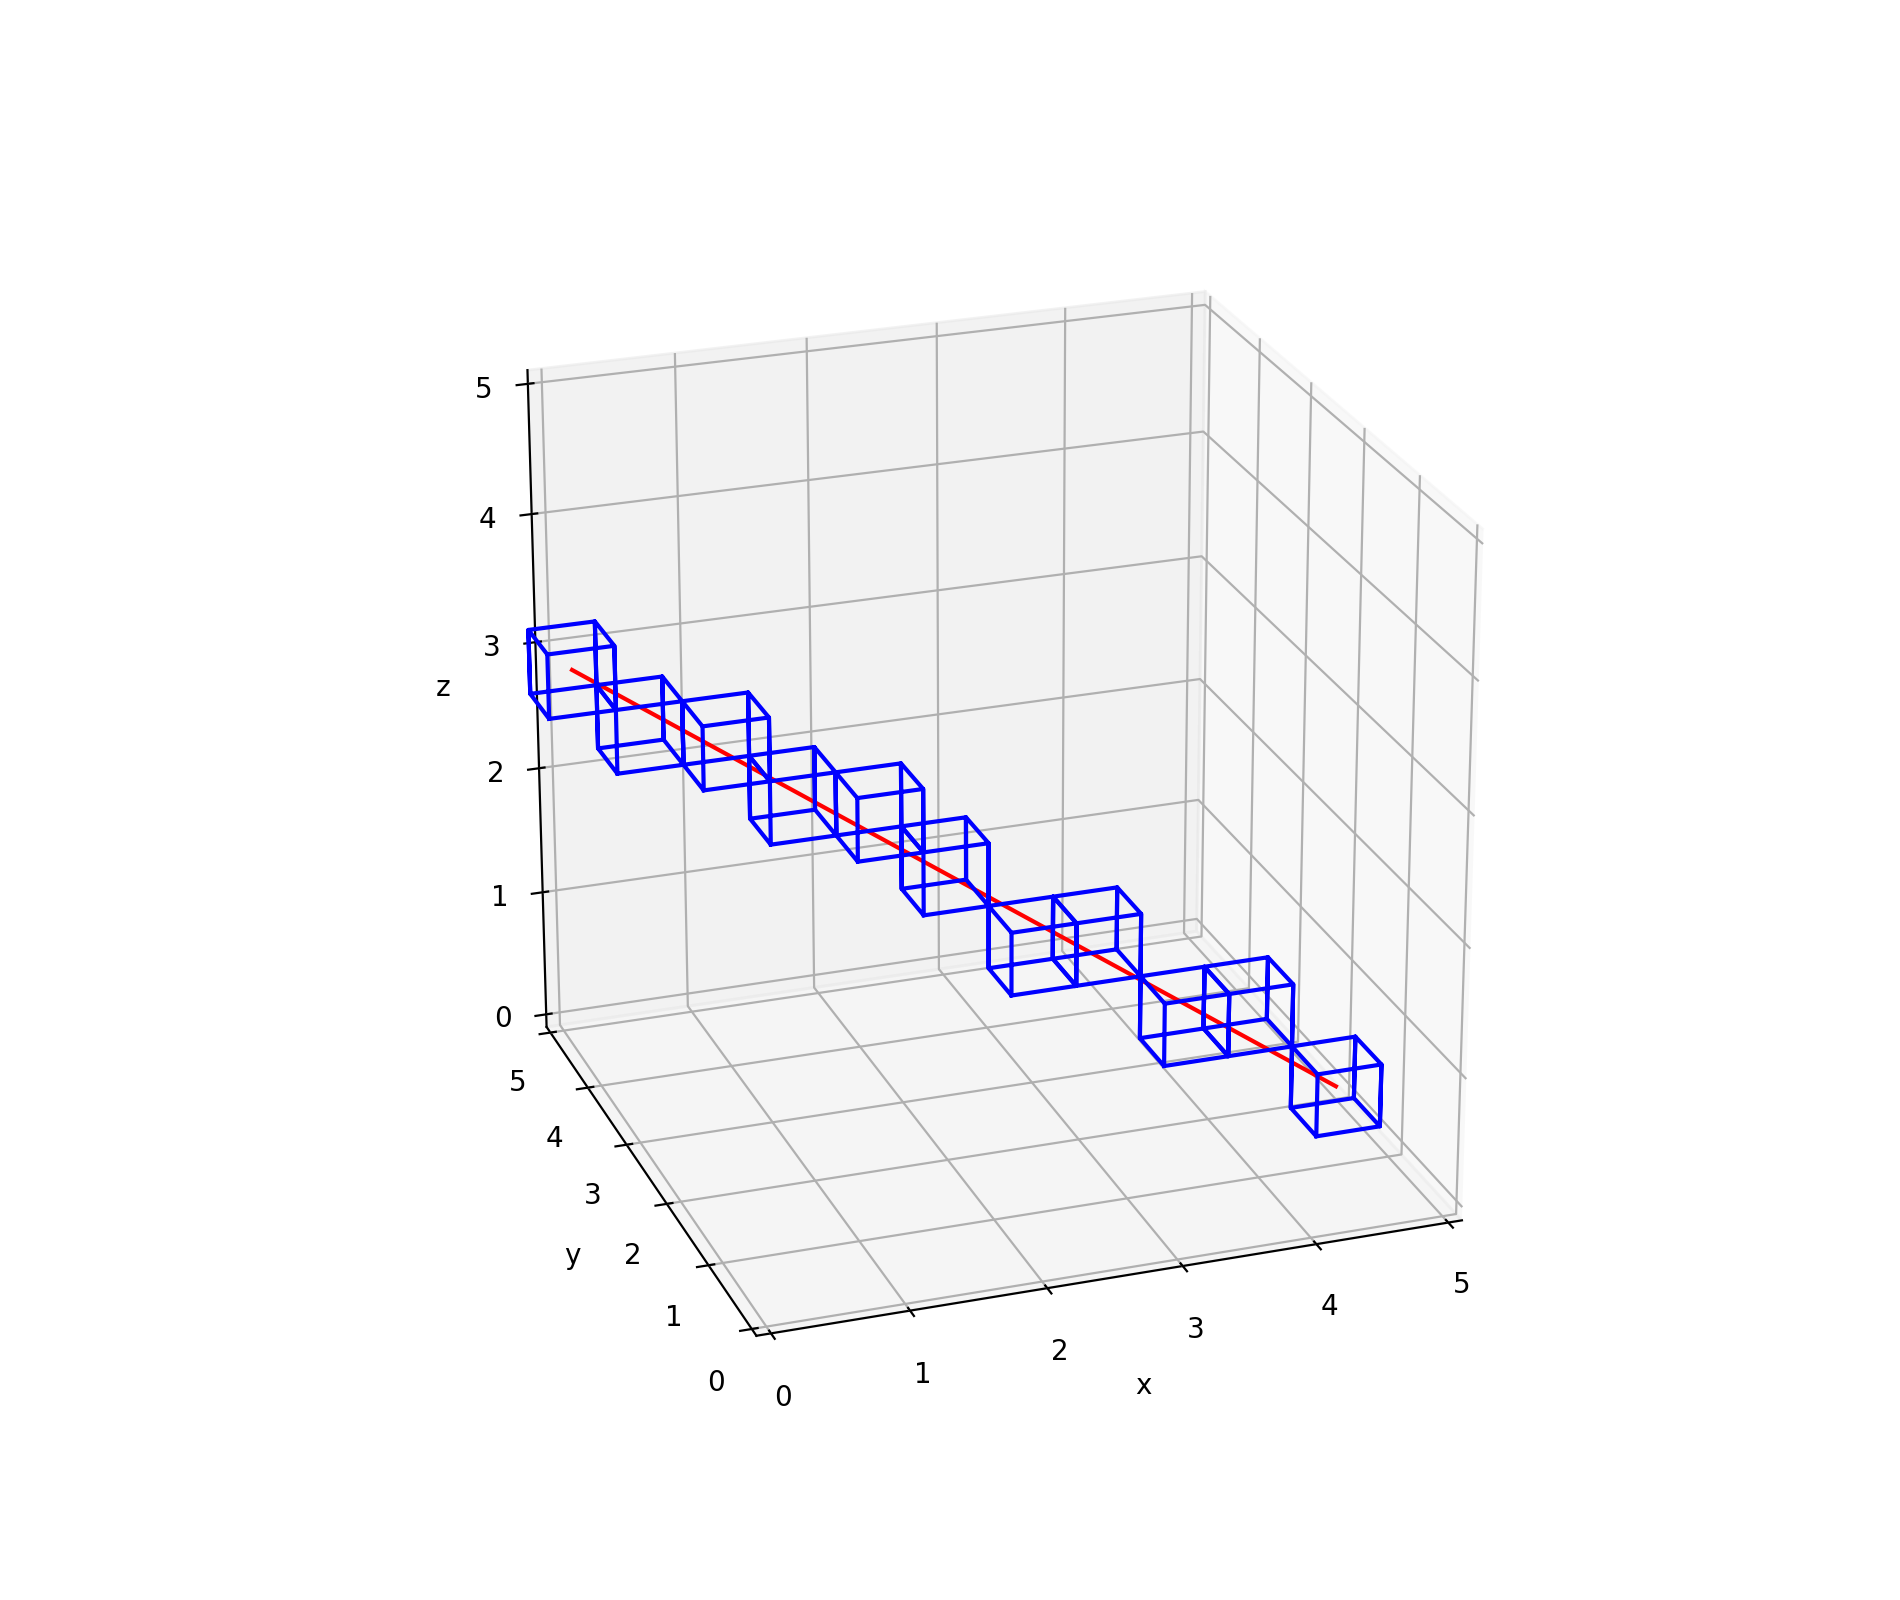

In [8]:
from plot_helpers import plot_voxel_line
fig = plot_voxel_line(voxels, step_size, a, start, target)